In [ ]:
# Debug cell - check correctness values in data
import torch
sample_batch = next(iter(DataLoader(DualEncoderDataset(train_data, Config.MAX_SEQ_LEN), batch_size=1)))
print("Sample batch correctness values:")
print(sample_batch['correctness'])
print(f"\nMin: {sample_batch['correctness'].min()}, Max: {sample_batch['correctness'].max()}")
print(f"Unique values: {torch.unique(sample_batch['correctness'])}")

# 🎯 Knowledge Tracing with Dual Encoder + LLM Pipeline

## Objective
Predict whether a student will answer a question **Correctly** or **Incorrectly** by combining:
1. **Context Encoder** - Text embeddings of question content and concept descriptions (supports Chinese)
2. **Sequence Encoder** - Student learning history embeddings (question/concept sequences)
3. **LLM** - Fine-tuned with LoRA for final prediction

## Architecture: Dual Encoder System
```
Question_i = ContextEncoder(question_text) + SequenceEncoder(question_sequence)
Concept_j = ContextEncoder(concept_text) + SequenceEncoder(concept_sequence)
```

## Pipeline Overview
| Step | Description |
|------|-------------|
| 1. Setup | Load config, select preset, initialize environment |
| 2. EDA | Load MOOCRadar dataset, build concept/question mappings |
| 3. Data Prep | Create data loaders with concept mapping (Chinese → IDs) |
| 4. Embedding Model | Initialize dual encoder (Context + Sequence) |
| 5. LLM Fine-tuning | Train KnowledgeTracingLLM with embedded prompts |
| 6. Evaluation | Test predictions and compute metrics |

## Model Presets
- **small**: TinyLlama-1.1B, minimal data, for quick testing
- **standard**: Phi-2, balanced performance  
- **phi3**: Phi-3 Mini, excellent quality
- **qwen**: Qwen2-1.5B, excellent for Chinese content
- **llama2**: Llama-2-7B, highest quality (needs more GPU)

## New Modular Architecture
- `models/encoders.py` - ContextEncoder, SequenceEncoder
- `models/embedding_model.py` - KTEmbeddingModel
- `models/kt_llm.py` - KnowledgeTracingLLM with prompt formatting
- `utils/concept_mapping.py` - ConceptMapper, QuestionMapper
- `utils/data_loader.py` - Data loading utilities

In [18]:
# ============================================================================
# STEP 1: SETUP - Load Configuration & Initialize Environment
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime
import importlib

warnings.filterwarnings('ignore')

# Load environment variables (includes proxy settings, WandB API key, and HF token)
load_dotenv()

# Set proxy environment variables for network requests
if os.getenv('HTTP_PROXY'):
    os.environ['HTTP_PROXY'] = os.getenv('HTTP_PROXY')
    os.environ['HTTPS_PROXY'] = os.getenv('HTTPS_PROXY')
    os.environ['http_proxy'] = os.getenv('http_proxy')
    os.environ['https_proxy'] = os.getenv('https_proxy')
    print("✓ Proxy settings loaded from .env file")
    print(f"  HTTP Proxy: {os.environ['HTTP_PROXY']}")

# Set Hugging Face token for model downloads
if os.getenv('HF_TOKEN'):
    os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
    os.environ['HUGGING_FACE_HUB_TOKEN'] = os.getenv('HF_TOKEN')
    print("✓ Hugging Face token loaded from .env file")

# Load configuration (with reload to get latest changes)
import config
importlib.reload(config)
from config import Config

# ============================================================================
# SELECT YOUR PRESET HERE
# ============================================================================
# Options: "small" (testing), "standard" (balanced), "phi3", "qwen" (Chinese), "llama2"

PRESET = "small"  # ← Change this to switch models

# Apply the preset
Config.use_preset(PRESET)

# Show available presets
print("\n")
Config.list_presets()

# Show full configuration
print("\n")
Config.print_config()

# ============================================================================
# CREATE ALL NECESSARY DIRECTORIES
# ============================================================================
print("\n" + "=" * 70)
print("CREATING DIRECTORY STRUCTURE")
print("=" * 70)

directories_to_create = [
    (Config.AKT_CHECKPOINT_DIR, "AKT Model Checkpoints"),
    (Config.LLM_CHECKPOINT_DIR, "LLM Model Checkpoints"),
    (Config.CHECKPOINT_DIR, "General Checkpoints"),
    (Config.EMBEDDING_DIR, "Student Embeddings"),
    (Config.OUTPUT_DIR, "Training Outputs & Plots"),
    (Config.AKT_LOG_DIR, "Training Logs"),
    (Config.DATA_DIR, "Dataset Files"),
    (Config.MAPPINGS_DIR, "Concept/Question Mappings"),
    ('assets', "Visualizations & Assets"),
    ('cache/embeddings', "Embedding Cache")
]

for dir_path, description in directories_to_create:
    os.makedirs(dir_path, exist_ok=True)
    print(f"  ✓ {description:30} → {dir_path}")

print("=" * 70)
print("✓ All directories created successfully")
print("=" * 70)

print(f"\n✓ Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✓ Proxy settings loaded from .env file
  HTTP Proxy: http://10.61.11.42:3128
✓ Hugging Face token loaded from .env file
✓ Applied preset: Small (Testing)
  Minimal configuration for quick testing and debugging
  LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Embedding dim: 768 → LLM hidden: 2048
✓ Applied preset: Small (Testing)
  Minimal configuration for quick testing and debugging
  LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Embedding dim: 768 → LLM hidden: 2048



AVAILABLE MODEL PRESETS

📦 small ← ACTIVE
   Name: Small (Testing)
   Description: Minimal configuration for quick testing and debugging
   LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
   Hidden Size: 2048
   Data: 5 users, 100 interactions

📦 standard
   Name: Standard (Balanced)
   Description: Balanced configuration for good results with reasonable resources
   LLM: microsoft/phi-2
   Hidden Size: 2560
   Data: 100 users, 5000 interactions

📦 phi3
   Name: Phi-3 Mini
   Description: Microsoft Phi-3 Mini - excellent performance fo

## Step 2: Load Dataset & Build Concept Mappings

In this section we:
1. Download/cache MOOCRadar dataset from Google Drive
2. Load problems and student interactions
3. **Build concept mappings** (Chinese concept names → numeric IDs)
4. Explore data distributions
5. Prepare data loaders using the new modular utilities

LOADING MOOCRADAR DATASET

[2.0] Checking dataset files...
✓ Using cached file: dataset/MOOCRadar/problem.json
✓ Using cached file: dataset/MOOCRadar/student-problem-coarse-flattened.json

[2.1] Building concept and question mappings...
  → Loaded question mapping (9383 questions) from mappings/small\question_mapping.pkl
  → Loaded concept mapping (9985 concepts) from mappings/small\concept_mapping.pkl

✓ Question Mapper: 9383 questions
✓ Concept Mapper: 9985 concepts

Sample Concept Mappings (Chinese → ID):
  • '反馈' → CID=8094 (count: 133)
  • '电子科学与技术' → CID=7898 (count: 112)
  • '放大电路' → CID=7909 (count: 84)
  • '数据挖掘' → CID=6961 (count: 70)
  • '机器学习' → CID=6803 (count: 69)

[2.2] Loading problem database...
  → Loading problems from dataset/MOOCRadar/problem.json...
  → Loaded 9383 problems

Sample problem structure:
  • problem_id: Pm_2046133
  • concepts: ['经济发展逻辑', '逻辑学']...
  • text (truncated): {'problem_id': 2046133, 'title': '第一章作业', 'content': '“经济发展有其内在的逻辑，一旦违背其内在逻辑，经济就要出

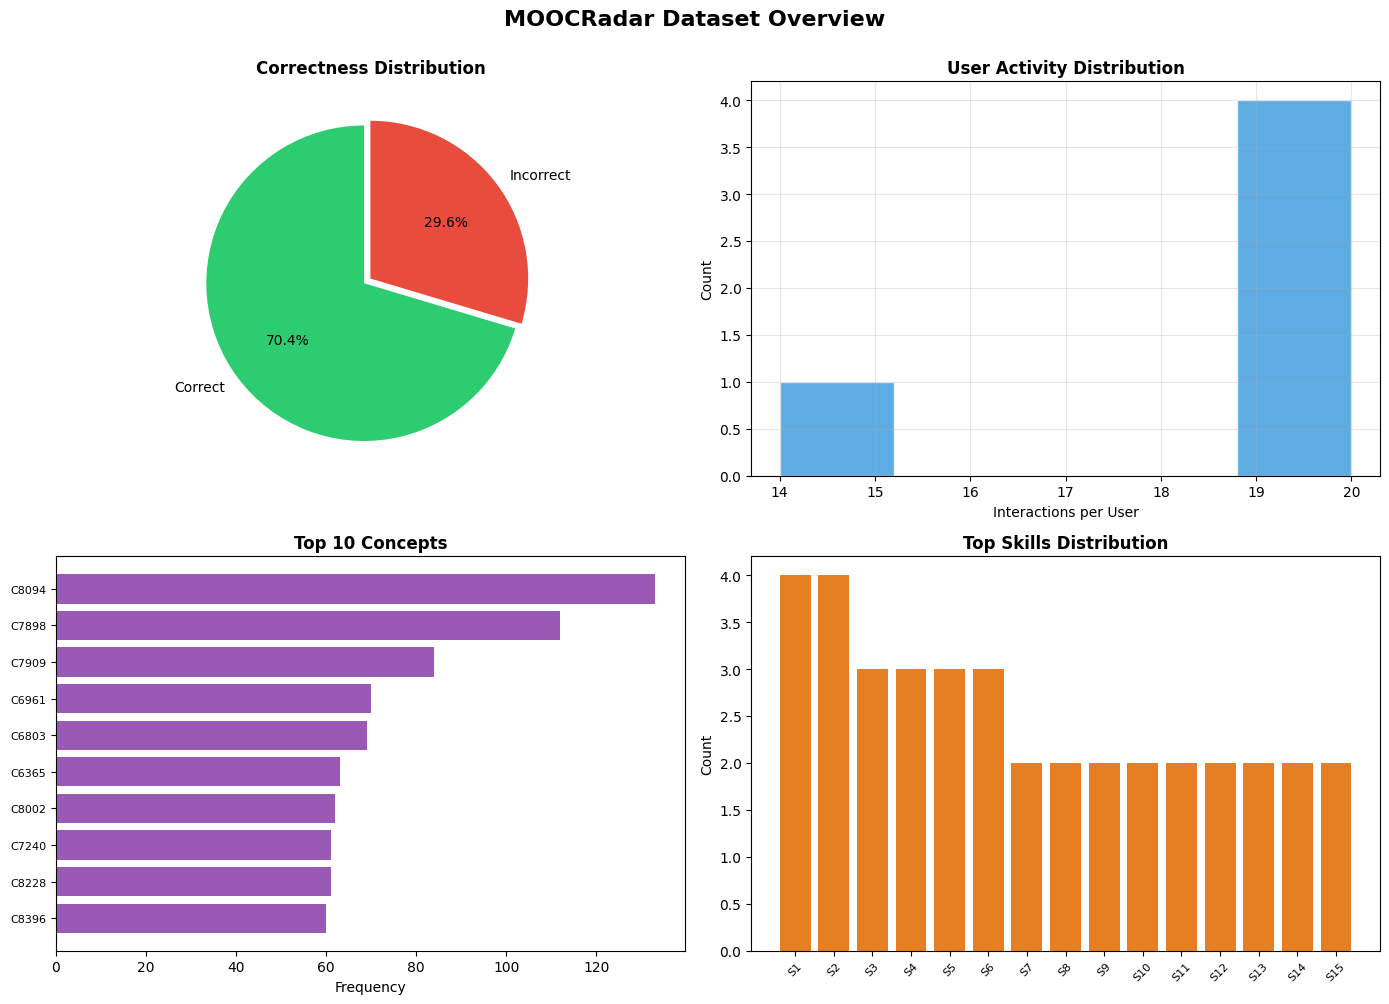


✓ Visualization saved to: assets/dataset_analysis.png

DATA LOADING & MAPPING COMPLETE
  → Questions: 9384
  → Concepts: 9986


In [19]:
# ============================================================================
# STEP 2: LOAD DATASET & BUILD CONCEPT MAPPINGS
# ============================================================================

print("=" * 70)
print("LOADING MOOCRADAR DATASET")
print("=" * 70)

# -----------------------------------------------------------------------------
# 2.0 Download Dataset from Google Drive (with caching)
# -----------------------------------------------------------------------------
def download_from_gdrive(file_id, output_path):
    """Download file from Google Drive if not already cached locally."""
    if os.path.exists(output_path):
        print(f"✓ Using cached file: {output_path}")
        return output_path
    
    print(f"⬇️  Downloading from Google Drive to {output_path}...")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    try:
        import gdown
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, output_path, quiet=False)
        print(f"✓ Download complete: {output_path}")
        return output_path
    except ImportError:
        print("⚠️  gdown not installed. Installing...")
        import subprocess
        subprocess.check_call([os.sys.executable, "-m", "pip", "install", "gdown", "--quiet"])
        import gdown
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, output_path, quiet=False)
        print(f"✓ Download complete: {output_path}")
        return output_path

print("\n[2.0] Checking dataset files...")

# Download/cache files
problem_json_path = download_from_gdrive(
    Config.GDRIVE_FILES["problem.json"],
    Config.PROBLEM_JSON
)
student_json_path = download_from_gdrive(
    Config.GDRIVE_FILES["student-problem-coarse-flattened.json"],
    Config.STUDENT_JSON
)

# -----------------------------------------------------------------------------
# 2.1 Build Concept & Question Mappings using our new utilities
# -----------------------------------------------------------------------------
print("\n[2.1] Building concept and question mappings...")

from utils import (
    ConceptMapper, QuestionMapper, 
    build_mappings_from_dataset, load_mappings,
    ProblemDatabase, StudentInteractions
)

# Try to load existing mappings, or build new ones
try:
    question_mapper, concept_mapper = load_mappings(Config.MAPPINGS_DIR)
except FileNotFoundError:
    print("  → Building new mappings from dataset...")
    question_mapper, concept_mapper = build_mappings_from_dataset(
        problem_json_path, 
        Config.MAPPINGS_DIR
    )

print(f"\n✓ Question Mapper: {question_mapper.num_questions} questions")
print(f"✓ Concept Mapper: {concept_mapper.num_concepts} concepts")

# Show some sample concept mappings (Chinese → ID)
print("\nSample Concept Mappings (Chinese → ID):")
concept_stats = concept_mapper.get_statistics()
for concept_name, count in concept_stats['top_concepts'][:5]:
    concept_id = concept_mapper.get_id(concept_name, add_if_missing=False)
    print(f"  • '{concept_name}' → CID={concept_id} (count: {count})")

# -----------------------------------------------------------------------------
# 2.2 Load Problem Database using our utility
# -----------------------------------------------------------------------------
print("\n[2.2] Loading problem database...")

problem_db = ProblemDatabase().load_from_file(problem_json_path)

# Sample problem
sample_pid = list(problem_db.problems.keys())[0]
sample_problem = problem_db.get_problem(sample_pid)
print(f"\nSample problem structure:")
print(f"  • problem_id: {sample_pid}")
print(f"  • concepts: {problem_db.get_concepts(sample_pid)[:3]}...")
print(f"  • text (truncated): {problem_db.get_text(sample_pid)[:100]}...")

# -----------------------------------------------------------------------------
# 2.3 Load Student Interactions
# -----------------------------------------------------------------------------
print("\n[2.3] Loading student interactions...")

interactions = StudentInteractions().load_from_file(student_json_path)
interactions.set_problem_database(problem_db)

print(f"✓ Loaded {interactions.num_interactions} interactions from {interactions.num_students} students")

# Sample interaction
sample_uid = interactions.get_all_students()[0]
sample_seq = interactions.get_student_sequence(sample_uid, max_length=5)
print(f"\nSample student {sample_uid}:")
for i, inter in enumerate(sample_seq[:3]):
    pid = inter.get('problem_id', '')
    concepts = problem_db.get_concepts(pid)
    print(f"  {i+1}. Problem: {pid}, Concepts: {concepts[:2]}")

# -----------------------------------------------------------------------------
# 2.4 Exploratory Data Analysis
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Convert to DataFrame for visualization
data_sample = []
all_students = interactions.get_all_students()[:Config.MAX_USERS]

for uid in all_students[:Config.MAX_USERS]:
    for inter in interactions.get_student_sequence(uid)[:Config.MAX_INTERACTIONS // Config.MAX_USERS]:
        pid = inter.get('problem_id', '')
        concepts = problem_db.get_concepts(pid)
        data_sample.append({
            'user_id': uid,
            'problem_id': pid,
            'skill_id': concept_mapper.get_id(concepts[0]) if concepts else 0,
            'is_correct': inter.get('score', inter.get('is_correct', 0))
        })

df = pd.DataFrame(data_sample)

print(f"\n📊 Dataset Overview (sampled):")
print(f"  • Total interactions: {len(df):,}")
print(f"  • Unique users: {df['user_id'].nunique():,}")
print(f"  • Unique problems: {df['problem_id'].nunique():,}")
print(f"  • Unique skills: {df['skill_id'].nunique():,}")

# Correctness distribution
if len(df) > 0:
    correct_rate = df['is_correct'].mean()
    print(f"\n📈 Correctness Distribution:")
    print(f"  • Correct: {df['is_correct'].sum():,} ({correct_rate*100:.1f}%)")
    print(f"  • Incorrect: {(df['is_correct'] == 0).sum():,} ({(1-correct_rate)*100:.1f}%)")

    # Interactions per user
    interactions_per_user = df.groupby('user_id').size()
    print(f"\n👤 Interactions per User:")
    print(f"  • Mean: {interactions_per_user.mean():.1f}")
    print(f"  • Median: {interactions_per_user.median():.1f}")

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Correctness Distribution
    ax1 = axes[0, 0]
    colors = ['#2ecc71', '#e74c3c']
    correct_counts = [df['is_correct'].sum(), (df['is_correct'] == 0).sum()]
    ax1.pie(correct_counts, labels=['Correct', 'Incorrect'], colors=colors, autopct='%1.1f%%',
            startangle=90, explode=(0.05, 0))
    ax1.set_title('Correctness Distribution', fontsize=12, fontweight='bold')

    # 2. Interactions per User Distribution
    ax2 = axes[0, 1]
    ax2.hist(interactions_per_user, bins=min(30, len(interactions_per_user)), 
             color='#3498db', edgecolor='white', alpha=0.8)
    ax2.set_xlabel('Interactions per User', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.set_title('User Activity Distribution', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # 3. Top Concepts by frequency
    ax3 = axes[1, 0]
    top_concepts = [(n, c) for n, c in concept_stats['top_concepts'][:10]]
    if top_concepts:
        names = [f"C{concept_mapper.get_id(n)}" for n, _ in top_concepts]
        counts = [c for _, c in top_concepts]
        ax3.barh(range(len(names)), counts, color='#9b59b6')
        ax3.set_yticks(range(len(names)))
        ax3.set_yticklabels(names, fontsize=8)
        ax3.set_xlabel('Frequency', fontsize=10)
        ax3.set_title('Top 10 Concepts', fontsize=12, fontweight='bold')
        ax3.invert_yaxis()

    # 4. Questions per concept
    ax4 = axes[1, 1]
    skill_counts = df['skill_id'].value_counts().head(15)
    ax4.bar(range(len(skill_counts)), skill_counts.values, color='#e67e22')
    ax4.set_xticks(range(len(skill_counts)))
    ax4.set_xticklabels([f"S{i+1}" for i in range(len(skill_counts))], fontsize=8, rotation=45)
    ax4.set_ylabel('Count', fontsize=10)
    ax4.set_title('Top Skills Distribution', fontsize=12, fontweight='bold')

    plt.suptitle('MOOCRadar Dataset Overview', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    os.makedirs('assets', exist_ok=True)
    plt.savefig('assets/dataset_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Visualization saved to: assets/dataset_analysis.png")

# Store key variables for later cells
num_questions = question_mapper.vocab_size
num_concepts = concept_mapper.vocab_size

print("\n" + "=" * 70)
print("DATA LOADING & MAPPING COMPLETE")
print("=" * 70)
print(f"  → Questions: {num_questions}")
print(f"  → Concepts: {num_concepts}")

## Step 3: Build Dual Encoder & Train Sequence Encoder

Our **Dual Encoder Architecture** consists of:

1. **Context Encoder** (pre-trained, multilingual-e5-base)
   - Encodes question text and concept descriptions
   - Supports Chinese text from MOOCRadar dataset
   
2. **Sequence Encoder** (trainable Transformer)
   - Captures student learning history patterns
   - Generates history embeddings per student

**Combined Formula:** `Embedding = Context(text) + Sequence(history)`

In [25]:
# ============================================================================
# STEP 3: BUILD DUAL ENCODER MODEL
# ============================================================================

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import importlib

print("=" * 70)
print("STEP 3: BUILD DUAL ENCODER MODEL")
print("=" * 70)

# -----------------------------------------------------------------------------
# 3.1 Import our modules (with reload to pick up latest changes)
# -----------------------------------------------------------------------------
print("\n[3.1] Importing modular components...")

# Reload modules to pick up latest code changes
import models
import utils
importlib.reload(models)
importlib.reload(utils)

from models import ContextEncoder, SequenceEncoder, HybridEncoder
from models import QuestionEmbedding, ConceptEmbedding, KTEmbeddingModel
from utils import KTDataset, create_data_loaders

print("✓ Imported from models/encoders.py: ContextEncoder, SequenceEncoder, HybridEncoder")
print("✓ Imported from models/embedding_model.py: QuestionEmbedding, ConceptEmbedding, KTEmbeddingModel")
print("✓ Imported from utils/data_loader.py: KTDataset, create_data_loaders")

# -----------------------------------------------------------------------------
# 3.2 Prepare Data for Training
# -----------------------------------------------------------------------------
print("\n[3.2] Preparing data for dual encoder training...")

# Build students_data from our loaded interactions
students_data = []
all_students = interactions.get_all_students()[:Config.MAX_USERS]

for uid in all_students:
    student_seq = interactions.get_student_sequence(uid, max_length=Config.MAX_SEQ_LEN)
    if len(student_seq) < 5:  # Skip students with too few interactions
        continue
    
    questions = []
    concepts = []
    correctness = []
    question_texts = []
    concept_texts = []
    
    for inter in student_seq:
        pid = inter.get('problem_id', '')
        concept_list = problem_db.get_concepts(pid)
        
        # Get numeric IDs - DON'T add new ones, use 0 for unknown
        qid = question_mapper.get_id(pid, add_if_missing=False)
        if qid == -1:  # Unknown question
            qid = 0
            
        if concept_list:
            cid = concept_mapper.get_id(concept_list[0], add_if_missing=False)
            if cid == -1:  # Unknown concept
                cid = 0
        else:
            cid = 0
        
        # Handle correctness with None value check
        score = inter.get('score')
        if score is None:
            score = inter.get('is_correct', 0)
        is_correct = int(score) if score is not None else 0
        
        questions.append(qid)
        concepts.append(cid)
        correctness.append(is_correct)
        
        # Store text for context encoding
        question_texts.append(problem_db.get_text(pid)[:512])  # Truncate long text
        concept_texts.append(concept_list[0] if concept_list else "Unknown")
    
    students_data.append({
        'user_id': uid,
        'questions': questions,
        'concepts': concepts,
        'correctness': correctness,
        'question_texts': question_texts,
        'concept_texts': concept_texts
    })

print(f"✓ Prepared {len(students_data)} students with sequences")

# Validate IDs are within range
max_qid = max(max(s['questions']) for s in students_data)
max_cid = max(max(s['concepts']) for s in students_data)
print(f"\n📊 Data validation:")
print(f"  • Max question ID in data: {max_qid} (vocab_size: {num_questions})")
print(f"  • Max concept ID in data: {max_cid} (vocab_size: {num_concepts})")

if max_qid >= num_questions:
    print(f"  ⚠️  WARNING: Max question ID ({max_qid}) >= vocab_size ({num_questions})")
if max_cid >= num_concepts:
    print(f"  ⚠️  WARNING: Max concept ID ({max_cid}) >= vocab_size ({num_concepts})")

# Split into train/val
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(
    students_data, 
    test_size=Config.TEST_SIZE, 
    random_state=Config.RANDOM_SEED
)
print(f"\n✓ Train: {len(train_data)} | Val: {len(val_data)}")

# -----------------------------------------------------------------------------
# 3.3 Dataset Class for Dual Encoder Training
# -----------------------------------------------------------------------------
class DualEncoderDataset(Dataset):
    """Dataset for Dual Encoder (Context + Sequence) training"""
    def __init__(self, students_data, max_seq_len=100):
        self.students = students_data
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return len(self.students)
    
    def __getitem__(self, idx):
        student = self.students[idx]
        questions = student['questions'][-self.max_seq_len:]
        concepts = student['concepts'][-self.max_seq_len:]
        correctness = student['correctness'][-self.max_seq_len:]
        
        seq_len = len(questions)
        pad_len = self.max_seq_len - seq_len
        
        # Pad sequences
        questions = questions + [0] * pad_len
        concepts = concepts + [0] * pad_len
        correctness = correctness + [0] * pad_len
        mask = [1] * seq_len + [0] * pad_len
        
        return {
            'questions': torch.LongTensor(questions),
            'concepts': torch.LongTensor(concepts),
            'correctness': torch.FloatTensor(correctness),
            'mask': torch.FloatTensor(mask),
            'user_id': student['user_id']
        }

# -----------------------------------------------------------------------------
# 3.4 Sequence Encoder Lightning Module
# -----------------------------------------------------------------------------
class SequenceEncoderLightning(pl.LightningModule):
    """Sequence Encoder for learning history - PyTorch Lightning wrapper"""
    
    def __init__(self, num_questions, num_concepts, embed_dim=768, num_heads=8, 
                 num_layers=2, dropout=0.15, learning_rate=5e-5, weight_decay=1e-4,
                 warmup_epochs=5, label_smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.warmup_epochs = warmup_epochs
        self.label_smoothing = label_smoothing
        
        # Use our SequenceEncoder from models/
        self.encoder = SequenceEncoder(
            num_questions=num_questions,
            num_concepts=num_concepts,
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout,
            max_seq_len=Config.MAX_SEQ_LEN
        )
        
        # Output layer for prediction
        self.output_layer = nn.Linear(embed_dim, 1)
        
    def forward(self, questions, concepts, correctness, mask):
        # Get sequence embeddings (returns tuple: question_emb, concept_emb)
        # We use question embeddings for knowledge tracing task
        question_hidden, concept_hidden = self.encoder(
            questions, concepts, correctness, mask, return_all_positions=True
        )
        
        # Use question hidden states for prediction
        output = self.output_layer(question_hidden).squeeze(-1)
        
        return output, question_hidden
    
    def training_step(self, batch, batch_idx):
        questions = batch['questions']
        concepts = batch['concepts']
        correctness = batch['correctness']
        mask = batch['mask']
        
        predictions, _ = self(questions, concepts, correctness, mask)
        
        # Shift for next-step prediction
        pred_shifted = predictions[:, :-1]
        target_shifted = correctness[:, 1:]
        mask_shifted = mask[:, 1:]
        
        loss = self._compute_loss(pred_shifted, target_shifted, mask_shifted)
        
        with torch.no_grad():
            pred_binary = (torch.sigmoid(pred_shifted) > 0.5).float()
            correct = ((pred_binary == target_shifted) * mask_shifted).sum()
            total = mask_shifted.sum()
            acc = correct / (total + 1e-8)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        questions = batch['questions']
        concepts = batch['concepts']
        correctness = batch['correctness']
        mask = batch['mask']
        
        predictions, _ = self(questions, concepts, correctness, mask)
        
        pred_shifted = predictions[:, :-1]
        target_shifted = correctness[:, 1:]
        mask_shifted = mask[:, 1:]
        
        loss = self._compute_loss(pred_shifted, target_shifted, mask_shifted)
        
        pred_binary = (torch.sigmoid(pred_shifted) > 0.5).float()
        correct = ((pred_binary == target_shifted) * mask_shifted).sum()
        total = mask_shifted.sum()
        acc = correct / (total + 1e-8)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def _compute_loss(self, predictions, targets, mask):
        smooth_targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
        loss = nn.functional.binary_cross_entropy_with_logits(
            predictions, smooth_targets, reduction='none'
        )
        masked_loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        return masked_loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=self.warmup_epochs, T_mult=2
        )
        return [optimizer], [scheduler]
    
    def get_embeddings(self, dataloader):
        """Extract sequence embeddings for all students"""
        self.eval()
        embeddings = []
        user_ids = []
        
        with torch.no_grad():
            for batch in dataloader:
                questions = batch['questions'].to(self.device)
                concepts = batch['concepts'].to(self.device)
                correctness = batch['correctness'].to(self.device)
                mask = batch['mask'].to(self.device)
                
                _, hidden = self(questions, concepts, correctness, mask)
                
                # Get last valid position embedding for each student
                for i in range(hidden.size(0)):
                    valid_len = int(mask[i].sum().item())
                    if valid_len > 0:
                        student_emb = hidden[i, valid_len - 1, :].cpu().numpy()
                    else:
                        student_emb = hidden[i, 0, :].cpu().numpy()
                    embeddings.append(student_emb)
                    user_ids.append(batch['user_id'][i])
        
        return np.array(embeddings), user_ids

# Create data module
class DualEncoderDataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, batch_size=64, max_seq_len=100):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len
        
    def setup(self, stage=None):
        self.train_dataset = DualEncoderDataset(self.train_data, self.max_seq_len)
        self.val_dataset = DualEncoderDataset(self.val_data, self.max_seq_len)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

print("\n✓ Dual Encoder components defined:")
print(f"  • DualEncoderDataset: Handles sequence padding and batching")
print(f"  • DualEncoderDataModule: PyTorch Lightning data module")
print(f"  • SequenceEncoderLightning: Transformer-based sequence encoder")
print(f"\nModel Configuration (from Config):")
print(f"  • Embedding Dim: {Config.EMBED_DIM}")
print(f"  • Attention Heads: {Config.NUM_HEADS}")
print(f"  • Sequence Encoder Layers: {Config.NUM_SEQ_LAYERS}")
print(f"  • Context Model: {Config.CONTEXT_MODEL}")
print(f"  • Combine Method: {Config.COMBINE_METHOD}")

STEP 3: BUILD DUAL ENCODER MODEL

[3.1] Importing modular components...
✓ Imported from models/encoders.py: ContextEncoder, SequenceEncoder, HybridEncoder
✓ Imported from models/embedding_model.py: QuestionEmbedding, ConceptEmbedding, KTEmbeddingModel
✓ Imported from utils/data_loader.py: KTDataset, create_data_loaders

[3.2] Preparing data for dual encoder training...
✓ Prepared 5 students with sequences

📊 Data validation:
  • Max question ID in data: 5861 (vocab_size: 9384)
  • Max concept ID in data: 6698 (vocab_size: 9986)

✓ Train: 4 | Val: 1

✓ Dual Encoder components defined:
  • DualEncoderDataset: Handles sequence padding and batching
  • DualEncoderDataModule: PyTorch Lightning data module
  • SequenceEncoderLightning: Transformer-based sequence encoder

Model Configuration (from Config):
  • Embedding Dim: 768
  • Attention Heads: 4
  • Sequence Encoder Layers: 2
  • Context Model: intfloat/multilingual-e5-base
  • Combine Method: add


In [26]:
# ============================================================================
# STEP 3.4: TRAIN SEQUENCE ENCODER
# ============================================================================

import wandb
from pytorch_lightning.loggers import WandbLogger

print("=" * 70)
print("TRAINING SEQUENCE ENCODER")
print("=" * 70)

# Initialize data module
print("\n[3.4.1] Setting up data module...")
data_module = DualEncoderDataModule(
    train_data=train_data,
    val_data=val_data,
    batch_size=Config.AKT_BATCH_SIZE, 
    max_seq_len=Config.MAX_SEQ_LEN
)
data_module.setup()
print(f"✓ Train: {len(data_module.train_dataset)} students")
print(f"✓ Val: {len(data_module.val_dataset)} students")

# Initialize sequence encoder model
print("\n[3.4.2] Initializing Sequence Encoder model...")
seq_encoder_model = SequenceEncoderLightning(
    num_questions=num_questions,
    num_concepts=num_concepts,
    embed_dim=Config.EMBED_DIM,
    num_heads=Config.NUM_HEADS,
    num_layers=Config.NUM_SEQ_LAYERS,
    dropout=Config.AKT_DROPOUT,
    learning_rate=Config.AKT_LR,
    weight_decay=Config.AKT_WEIGHT_DECAY,
    warmup_epochs=Config.AKT_WARMUP_EPOCHS,
    label_smoothing=Config.AKT_LABEL_SMOOTHING
)

trainable_params = sum(p.numel() for p in seq_encoder_model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {trainable_params:,} trainable parameters")

# Setup callbacks
print("\n[3.4.3] Setting up training callbacks...")
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=Config.AKT_CHECKPOINT_DIR,
    filename='seq-encoder-{epoch:02d}-{val_acc:.4f}',
    save_top_k=1,
    mode='max'
)

early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=Config.AKT_EARLY_STOP_PATIENCE,
    mode='max',
    min_delta=0.001
)

# Setup loggers
csv_logger = CSVLogger(Config.AKT_LOG_DIR, name='seq_encoder_training')
loggers = [csv_logger]

# Initialize wandb if enabled
if Config.USE_WANDB:
    wandb_run = wandb.init(
        entity=Config.WANDB_ENTITY,
        project=Config.WANDB_PROJECT,
        name=f"SeqEncoder-{Config.ACTIVE_PRESET}",
        config={
            "preset": Config.ACTIVE_PRESET,
            "model": "SequenceEncoder",
            "embed_dim": Config.EMBED_DIM,
            "num_heads": Config.NUM_HEADS,
            "num_layers": Config.NUM_SEQ_LAYERS,
            "batch_size": Config.AKT_BATCH_SIZE,
            "learning_rate": Config.AKT_LR,
            "epochs": Config.AKT_EPOCHS,
            "num_students": len(students_data),
            "num_questions": num_questions,
            "num_concepts": num_concepts,
            "context_model": Config.CONTEXT_MODEL,
        }
    )
    wandb_logger = WandbLogger(experiment=wandb_run)
    loggers.append(wandb_logger)
    print(f"✓ Wandb initialized: {wandb_run.name}")
    print(f"  → View at: {wandb_run.get_url()}")

# Initialize trainer
print("\n[3.4.4] Starting training...")
trainer = pl.Trainer(
    max_epochs=Config.AKT_EPOCHS,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=loggers,
    accelerator='auto' if Config.USE_GPU else 'cpu',
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
    accumulate_grad_batches=Config.GRADIENT_ACCUMULATION,
    precision='16-mixed' if Config.MIXED_PRECISION else 32,
    gradient_clip_val=1.0,
    gradient_clip_algorithm='norm'
)

print("\n" + "🏋️ " * 35)
trainer.fit(seq_encoder_model, data_module)
print("🏋️ " * 35)

print(f"\n✓ Training completed!")
print(f"✓ Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"✓ Best validation accuracy: {checkpoint_callback.best_model_score:.4f}")

# Load best model
print("\n[3.4.5] Loading best model for embedding extraction...")
best_seq_model = SequenceEncoderLightning.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    num_questions=num_questions,
    num_concepts=num_concepts
)
print("✓ Best sequence encoder model loaded")

# -----------------------------------------------------------------------------
# 3.5 Plot Training Curves
# -----------------------------------------------------------------------------
print("\n[3.5] Plotting training curves...")

metrics_path = f'{Config.AKT_LOG_DIR}/seq_encoder_training/version_{csv_logger.version}/metrics.csv'
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)
    print(f"Available columns: {list(metrics_df.columns)}")
    
    train_loss_col = None
    train_acc_col = None
    val_loss_col = None
    val_acc_col = None
    
    for col in metrics_df.columns:
        if 'train' in col.lower() and 'loss' in col.lower():
            train_loss_col = col
        elif 'train' in col.lower() and 'acc' in col.lower():
            train_acc_col = col
        elif 'val' in col.lower() and 'loss' in col.lower():
            val_loss_col = col
        elif 'val' in col.lower() and 'acc' in col.lower():
            val_acc_col = col
    
    if train_loss_col and val_loss_col:
        train_metrics = metrics_df[metrics_df[train_loss_col].notna()][['epoch', train_loss_col, train_acc_col]]
        train_metrics.columns = ['epoch', 'train_loss', 'train_acc']
        
        val_metrics = metrics_df[metrics_df[val_loss_col].notna()][['epoch', val_loss_col, val_acc_col]]
        val_metrics.columns = ['epoch', 'val_loss', 'val_acc']
        
        metrics_combined = pd.merge(
            train_metrics.groupby('epoch').mean().reset_index(),
            val_metrics.groupby('epoch').mean().reset_index(),
            on='epoch'
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].plot(metrics_combined['epoch'], metrics_combined['train_loss'], 'b-o', label='Train', markersize=6)
        axes[0].plot(metrics_combined['epoch'], metrics_combined['val_loss'], 'r-s', label='Val', markersize=6)
        axes[0].set_xlabel('Epoch', fontsize=11)
        axes[0].set_ylabel('Loss', fontsize=11)
        axes[0].set_title('Sequence Encoder Training - Loss', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(metrics_combined['epoch'], metrics_combined['train_acc'], 'b-o', label='Train', markersize=6)
        axes[1].plot(metrics_combined['epoch'], metrics_combined['val_acc'], 'r-s', label='Val', markersize=6)
        axes[1].set_xlabel('Epoch', fontsize=11)
        axes[1].set_ylabel('Accuracy', fontsize=11)
        axes[1].set_title('Sequence Encoder Training - Accuracy', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('assets/seq_encoder_training.png', dpi=300, bbox_inches='tight')
        print("✓ Training curves saved as 'assets/seq_encoder_training.png'")
        plt.show()
    else:
        print("⚠️ Could not find expected metric columns in CSV.")
else:
    print("⚠️ Metrics file not found. Skipping plot.")

print("\n" + "=" * 70)
print("✓ SEQUENCE ENCODER TRAINING COMPLETE")
print("=" * 70)

TRAINING SEQUENCE ENCODER

[3.4.1] Setting up data module...
✓ Train: 4 students
✓ Val: 1 students

[3.4.2] Initializing Sequence Encoder model...
  → SequenceEncoder initialized:
     Questions: 9384, Concepts: 9986
     Embed dim: 768, Layers: 2, Heads: 4
✓ Model initialized with 30,277,633 trainable parameters

[3.4.3] Setting up training callbacks...


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type            | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | encoder      | SequenceEncoder | 30.3 M | train | 0    
1 | output_layer | Linear          | 769    | train | 0    
-----------------------------------------------------------------
30.3 M    Trainable params
0         Non-trainable params
30.3 M    Total params
121.111   Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
0         Total Flops


✓ Wandb initialized: SeqEncoder-small
  → View at: https://wandb.ai/letrongducanh456-viettel/LLM-KT/runs/ju6pajd1

[3.4.4] Starting training...

🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             

IndexError: index out of range in self

## Step 4: Build Context Encoder & Extract Combined Embeddings

Now we build the **Context Encoder** and combine with Sequence embeddings:

1. **Context Embeddings** (from multilingual-e5-base)
   - Question text embedding via pre-trained model
   - Concept description embedding
   - Dimension: `EMBED_DIM` (768)

2. **Sequence Embeddings** (from trained Sequence Encoder)
   - Student learning history patterns
   - Dimension: `EMBED_DIM`

**Combined:** `Question_i = Context(text) + Sequence(history)`

In [ ]:
# ============================================================================
# STEP 4: BUILD CONTEXT ENCODER & EXTRACT COMBINED EMBEDDINGS
# ============================================================================

print("=" * 70)
print("STEP 4: BUILD CONTEXT ENCODER & EXTRACT EMBEDDINGS")
print("=" * 70)

# -----------------------------------------------------------------------------
# 4.1 Initialize Context Encoder
# -----------------------------------------------------------------------------
print("\n[4.1] Initializing Context Encoder...")

context_encoder = ContextEncoder(
    model_name=Config.CONTEXT_MODEL,
    embed_dim=Config.EMBED_DIM,
    freeze=Config.FREEZE_CONTEXT
)

print(f"✓ Context Encoder initialized:")
print(f"  • Model: {Config.CONTEXT_MODEL}")
print(f"  • Output dim: {Config.EMBED_DIM}")
print(f"  • Frozen: {Config.FREEZE_CONTEXT}")

# -----------------------------------------------------------------------------
# 4.2 Extract Sequence Embeddings
# -----------------------------------------------------------------------------
print("\n[4.2] Extracting sequence embeddings...")

best_seq_model.eval()
train_seq_embeddings, train_user_ids = best_seq_model.get_embeddings(data_module.train_dataloader())
val_seq_embeddings, val_user_ids = best_seq_model.get_embeddings(data_module.val_dataloader())

print(f"✓ Train sequence embeddings: {train_seq_embeddings.shape}")
print(f"✓ Val sequence embeddings: {val_seq_embeddings.shape}")

# -----------------------------------------------------------------------------
# 4.3 Extract Context Embeddings for unique questions/concepts
# -----------------------------------------------------------------------------
print("\n[4.3] Extracting context embeddings for questions and concepts...")

# Get unique question texts
unique_questions = {}
unique_concepts = {}

for student in students_data:
    for qid, cid, q_text, c_text in zip(
        student['questions'], 
        student['concepts'],
        student['question_texts'],
        student['concept_texts']
    ):
        if qid not in unique_questions:
            unique_questions[qid] = q_text
        if cid not in unique_concepts:
            unique_concepts[cid] = c_text

print(f"  • Unique questions: {len(unique_questions)}")
print(f"  • Unique concepts: {len(unique_concepts)}")

# Extract context embeddings
print("  → Encoding question texts...")
question_context_embeddings = {}
context_encoder.eval()

with torch.no_grad():
    for qid, text in unique_questions.items():
        emb = context_encoder([text]).cpu().numpy()
        question_context_embeddings[qid] = emb[0]

print("  → Encoding concept texts...")
concept_context_embeddings = {}

with torch.no_grad():
    for cid, text in unique_concepts.items():
        emb = context_encoder([text]).cpu().numpy()
        concept_context_embeddings[cid] = emb[0]

print(f"✓ Question context embeddings: {len(question_context_embeddings)}")
print(f"✓ Concept context embeddings: {len(concept_context_embeddings)}")

# -----------------------------------------------------------------------------
# 4.4 Save Embeddings
# -----------------------------------------------------------------------------
print("\n[4.4] Saving embeddings...")

os.makedirs(os.path.dirname(Config.TRAIN_EMBEDDINGS), exist_ok=True)
os.makedirs('cache/embeddings', exist_ok=True)

# Save sequence embeddings
np.save(Config.TRAIN_EMBEDDINGS, train_seq_embeddings)
np.save(Config.VAL_EMBEDDINGS, val_seq_embeddings)

# Save context embeddings
np.save('cache/embeddings/question_context.npy', 
        {k: v for k, v in question_context_embeddings.items()})
np.save('cache/embeddings/concept_context.npy',
        {k: v for k, v in concept_context_embeddings.items()})

print(f"\n✓ Embeddings saved:")
print(f"  • Sequence: {Config.TRAIN_EMBEDDINGS}, {Config.VAL_EMBEDDINGS}")
print(f"  • Context: cache/embeddings/question_context.npy, concept_context.npy")

# -----------------------------------------------------------------------------
# 4.5 Display Architecture Diagram
# -----------------------------------------------------------------------------
print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│               DUAL ENCODER EMBEDDING ARCHITECTURE                    │
├─────────────────────────────────────────────────────────────────────┤
│                                                                       │
│   CONTEXT ENCODER ({Config.CONTEXT_MODEL.split('/')[-1]}):                              │
│   ┌─────────────────┐                                                │
│   │ Question Text   │ → Encoder → Context Emb ({Config.EMBED_DIM}-dim)     │
│   │ Concept Text    │ → Encoder → Context Emb ({Config.EMBED_DIM}-dim)     │
│   └────────┬────────┘                                                │
│            │                                                          │
│   SEQUENCE ENCODER (Trained Transformer):                           │
│   ┌─────────────────┐                                                │
│   │ Learning History│ → Encoder → Sequence Emb ({Config.EMBED_DIM}-dim)    │
│   └────────┬────────┘                                                │
│            │                                                          │
│   COMBINATION ({Config.COMBINE_METHOD}):                                            │
│   ┌─────────────────────────────────────────┐                        │
│   │ Question Emb = Context + Sequence       │                        │
│   │ Concept Emb = Context + Sequence        │                        │
│   └────────┬────────┘                                                │
│            │                                                          │
│            ▼                                                          │
│   ┌─────────────────────────────────────────┐                        │
│   │      [QuesEmbed] + [ConcEmbed]          │                        │
│   │              ↓                          │                        │
│   │     LLM (with LoRA fine-tuning)         │                        │
│   │              ↓                          │                        │
│   │      Predict: Yes / No                  │                        │
│   └─────────────────────────────────────────┘                        │
│                                                                       │
└─────────────────────────────────────────────────────────────────────┘
""")

print("=" * 70)
print("✓ EMBEDDING EXTRACTION COMPLETE")
print("=" * 70)

STEP 4: EXTRACT EMBEDDINGS FOR LLM FINE-TUNING

[4.1] Extracting student history embeddings from AKT...


✓ Train embeddings shape: (2, 768)
✓ Val embeddings shape: (1, 768)
✓ Embedding dimension: 768

✓ Embeddings saved to:
  • embeddings/small/student_embeddings_train.npy
  • embeddings/small/student_embeddings_val.npy

[4.2] Designing embedding adapter...

Embedding Adapter Configuration:
  • AKT Embedding Dim: 768
  • LLM Hidden Size: 2048
  • Adapter Hidden Dim: 1408
  • Num Soft Tokens: 4

┌─────────────────────────────────────────────────────────────────────┐
│                    EMBEDDING FLOW ARCHITECTURE                       │
├─────────────────────────────────────────────────────────────────────┤
│                                                                       │
│   STUDENT HISTORY CONTEXT (from AKT):                                │
│   ┌─────────────────┐                                                │
│   │  AKT Embeddings │ (768-dim)                             │
│   └────────┬────────┘                                                │
│            │                 

In [ ]:
# ============================================================================
# STEP 5: LLM MODEL DEFINITION (USING MODULAR COMPONENTS)
# ============================================================================

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch.nn.functional as F

print("=" * 70)
print("STEP 5: DEFINE LLM MODEL WITH DUAL ENCODER EMBEDDINGS")
print("=" * 70)

# -----------------------------------------------------------------------------
# 5.1 Import our modular KnowledgeTracingLLM
# -----------------------------------------------------------------------------
print("\n[5.1] Importing modular LLM components...")

from models import KnowledgeTracingLLM, PromptFormatter, KTEmbeddingModel

print("✓ Imported from models/kt_llm.py: KnowledgeTracingLLM, PromptFormatter")
print("✓ Imported from models/embedding_model.py: KTEmbeddingModel")

# -----------------------------------------------------------------------------
# 5.2 Build KT Embedding Model (combines Context + Sequence encoders)
# -----------------------------------------------------------------------------
print("\n[5.2] Building KT Embedding Model...")

# Initialize the embedding model
kt_embedding_model = KTEmbeddingModel(
    num_questions=num_questions,
    num_concepts=num_concepts,
    embed_dim=Config.EMBED_DIM,
    context_model=Config.CONTEXT_MODEL,
    num_seq_layers=Config.NUM_SEQ_LAYERS,
    num_heads=Config.NUM_HEADS,
    dropout=Config.AKT_DROPOUT,
    combine_method=Config.COMBINE_METHOD,
    freeze_context=Config.FREEZE_CONTEXT
)

# Load the trained sequence encoder weights
print("  → Loading trained sequence encoder weights...")
seq_encoder_state = best_seq_model.encoder.state_dict()
kt_embedding_model.question_embedding.sequence_encoder.load_state_dict(seq_encoder_state)
kt_embedding_model.concept_embedding.sequence_encoder.load_state_dict(seq_encoder_state)
print("✓ Sequence encoder weights loaded")

print(f"\nKT Embedding Model Configuration:")
print(f"  • Context Model: {Config.CONTEXT_MODEL}")
print(f"  • Embed Dim: {Config.EMBED_DIM}")
print(f"  • Combine Method: {Config.COMBINE_METHOD}")

# -----------------------------------------------------------------------------
# 5.3 Dataset for LLM Fine-tuning
# -----------------------------------------------------------------------------
class KTDualEncoderDataset(Dataset):
    """Dataset for fine-tuning LLM with dual encoder embeddings."""
    
    def __init__(self, students_data, kt_embedding_model, tokenizer, 
                 question_context_emb, concept_context_emb, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.question_context_emb = question_context_emb
        self.concept_context_emb = concept_context_emb
        
        # Create prompt formatter
        self.formatter = PromptFormatter(tokenizer)
        
        # Flatten to individual predictions
        self.samples = []
        for student in students_data:
            questions = student['questions']
            concepts = student['concepts']
            correctness = student['correctness']
            question_texts = student['question_texts']
            concept_texts = student['concept_texts']
            
            for t in range(1, len(questions)):
                self.samples.append({
                    'question_id': questions[t],
                    'concept_id': concepts[t],
                    'question_text': question_texts[t][:200],
                    'concept_text': concept_texts[t],
                    'correctness': correctness[t],
                    'history_questions': questions[:t],
                    'history_concepts': concepts[:t],
                    'history_correctness': correctness[:t],
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Get context embeddings (pre-computed)
        qid = sample['question_id']
        cid = sample['concept_id']
        
        question_ctx_emb = torch.FloatTensor(
            self.question_context_emb.get(qid, np.zeros(Config.EMBED_DIM))
        )
        concept_ctx_emb = torch.FloatTensor(
            self.concept_context_emb.get(cid, np.zeros(Config.EMBED_DIM))
        )
        
        # Prepare history for sequence encoder
        history_len = len(sample['history_questions'])
        max_hist = Config.MAX_SEQ_LEN
        pad_len = max(0, max_hist - history_len)
        
        hist_questions = sample['history_questions'][-max_hist:] + [0] * pad_len
        hist_concepts = sample['history_concepts'][-max_hist:] + [0] * pad_len
        hist_correctness = sample['history_correctness'][-max_hist:] + [0] * pad_len
        hist_mask = [1] * min(history_len, max_hist) + [0] * pad_len
        
        # Format prompt using our PromptFormatter
        prompt = self.formatter.format_prediction_prompt(
            question_id=qid,
            concept_name=sample['concept_text'],
            difficulty="medium",
            content=sample['question_text'][:100]
        )
        
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        
        return {
            'question_ctx_emb': question_ctx_emb,
            'concept_ctx_emb': concept_ctx_emb,
            'history_questions': torch.LongTensor(hist_questions),
            'history_concepts': torch.LongTensor(hist_concepts),
            'history_correctness': torch.FloatTensor(hist_correctness),
            'history_mask': torch.FloatTensor(hist_mask),
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.LongTensor([1 if sample['correctness'] else 0]).squeeze(0),
            'question_id': qid,
            'concept_id': cid
        }

print("\n✓ KTDualEncoderDataset class defined")
print(f"\nUsing LLM: {Config.LLM_MODEL_NAME}")
print(f"Embedding: {Config.EMBED_DIM} → {Config.LLM_HIDDEN_SIZE}")

# Display model info table
print(f"""
┌────────────────────────────────────────────────────────────┐
│                  LLM MODEL CONFIGURATION                    │
├────────────────────────────────────────────────────────────┤
│  LLM Model:        {Config.LLM_MODEL_NAME:<38} │
│  LLM Hidden Size:  {Config.LLM_HIDDEN_SIZE:<38} │
│  Embed Dim:        {Config.EMBED_DIM:<38} │
│  LoRA r:           {Config.LORA_R:<38} │
│  LoRA alpha:       {Config.LORA_ALPHA:<38} │
│  Soft Tokens:      {Config.NUM_SOFT_TOKENS:<38} │
│  Combine Method:   {Config.COMBINE_METHOD:<38} │
└────────────────────────────────────────────────────────────┘
""")

STEP 5: DEFINE LLM MODEL WITH EMBEDDING ADAPTER

✓ KnowledgeTracingLLM class defined
✓ KTLlamaDataset class defined

Using LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Embedding: 768 → 2048


In [ ]:
# ============================================================================
# STEP 5.2: LLM FINE-TUNING WITH DUAL ENCODER
# ============================================================================

from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
import json
from datetime import datetime

print("=" * 70)
print("STEP 5.2: FINE-TUNE LLM WITH DUAL ENCODER EMBEDDINGS")
print("=" * 70)

# -----------------------------------------------------------------------------
# 5.2.1 Initialize the KnowledgeTracingLLM model
# -----------------------------------------------------------------------------
print("\n[5.2.1] Initializing LLM Model...")

kt_llm = KnowledgeTracingLLM(
    model_name=Config.LLM_MODEL_NAME,
    embed_dim=Config.EMBED_DIM,
    llm_hidden_size=Config.LLM_HIDDEN_SIZE,
    num_soft_tokens=Config.NUM_SOFT_TOKENS,
    lora_r=Config.LORA_R,
    lora_alpha=Config.LORA_ALPHA,
    lora_dropout=Config.LORA_DROPOUT
)

# -----------------------------------------------------------------------------
# 5.2.2 Prepare datasets
# -----------------------------------------------------------------------------
print("\n[5.2.2] Preparing Datasets...")

train_dataset = KTDualEncoderDataset(
    students_data=train_data,
    kt_embedding_model=kt_embedding_model,
    tokenizer=kt_llm.tokenizer,
    question_context_emb=question_context_embeddings,
    concept_context_emb=concept_context_embeddings,
    max_length=Config.MAX_PROMPT_LENGTH
)

val_dataset = KTDualEncoderDataset(
    students_data=val_data,
    kt_embedding_model=kt_embedding_model,
    tokenizer=kt_llm.tokenizer,
    question_context_emb=question_context_embeddings,
    concept_context_emb=concept_context_embeddings,
    max_length=Config.MAX_PROMPT_LENGTH
)

print(f"  → Train samples: {len(train_dataset):,}")
print(f"  → Val samples: {len(val_dataset):,}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=Config.LLM_BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=Config.LLM_BATCH_SIZE, shuffle=False, num_workers=0)

# -----------------------------------------------------------------------------
# 5.2.3 Initialize WandB for LLM training
# -----------------------------------------------------------------------------
print("\n[5.2.3] Initializing WandB...")

if Config.USE_WANDB:
    wandb.init(
        project=Config.WANDB_PROJECT,
        entity=Config.WANDB_ENTITY,
        name=f"llm-{Config.ACTIVE_PRESET}-{datetime.now().strftime('%Y%m%d_%H%M')}",
        config={
            "preset": Config.ACTIVE_PRESET,
            "llm_model": Config.LLM_MODEL_NAME,
            "llm_hidden_size": Config.LLM_HIDDEN_SIZE,
            "embed_dim": Config.EMBED_DIM,
            "context_model": Config.CONTEXT_MODEL,
            "num_soft_tokens": Config.NUM_SOFT_TOKENS,
            "combine_method": Config.COMBINE_METHOD,
            "lora_r": Config.LORA_R,
            "lora_alpha": Config.LORA_ALPHA,
            "llm_batch_size": Config.LLM_BATCH_SIZE,
            "llm_epochs": Config.LLM_EPOCHS,
            "llm_lr": Config.LLM_LR,
            "train_samples": len(train_dataset),
            "val_samples": len(val_dataset)
        }
    )
    print(f"✓ WandB initialized: {wandb.run.name}")
else:
    print("⚠️ WandB disabled, logging locally only")

# -----------------------------------------------------------------------------
# 5.2.4 Training setup
# -----------------------------------------------------------------------------
print("\n[5.2.4] Setting up optimizer and loss...")

# Optimizer - Train adapter + classifier + LoRA weights
llm_optimizer = optim.AdamW([
    {'params': kt_llm.embedding_adapter.parameters(), 'lr': Config.LLM_LR},
    {'params': kt_llm.classifier.parameters(), 'lr': Config.LLM_LR},
    {'params': kt_llm.llm.parameters(), 'lr': Config.LLM_LR * 0.1}  # Lower LR for LoRA
], weight_decay=0.01)

criterion = nn.CrossEntropyLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kt_llm = kt_llm.to(device)
kt_embedding_model = kt_embedding_model.to(device)

print(f"  → Device: {device}")
print(f"  → Learning rate: {Config.LLM_LR}")
print(f"  → Epochs: {Config.LLM_EPOCHS}")

# -----------------------------------------------------------------------------
# 5.2.5 Training loop
# -----------------------------------------------------------------------------
print("\n[5.2.5] Starting LLM Fine-tuning...")

best_val_acc = 0.0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(Config.LLM_EPOCHS):
    # Training phase
    kt_llm.train()
    kt_embedding_model.eval()  # Keep embedding model in eval mode
    
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.LLM_EPOCHS} [Train]")
    for batch in progress_bar:
        # Get context embeddings
        question_ctx_emb = batch['question_ctx_emb'].to(device)
        concept_ctx_emb = batch['concept_ctx_emb'].to(device)
        
        # Get sequence embeddings from history
        hist_questions = batch['history_questions'].to(device)
        hist_concepts = batch['history_concepts'].to(device)
        hist_correctness = batch['history_correctness'].to(device)
        hist_mask = batch['history_mask'].to(device)
        
        with torch.no_grad():
            # Get sequence embeddings
            seq_emb = kt_embedding_model.question_embedding.sequence_encoder(
                hist_questions, hist_concepts, hist_correctness, hist_mask
            )
            # Get last valid position
            batch_size = seq_emb.size(0)
            seq_lengths = hist_mask.sum(dim=1).long()
            seq_emb_final = torch.stack([
                seq_emb[i, max(0, seq_lengths[i].item() - 1), :] 
                for i in range(batch_size)
            ])
        
        # Combine context + sequence embeddings
        if Config.COMBINE_METHOD == 'add':
            combined_emb = question_ctx_emb + seq_emb_final
        elif Config.COMBINE_METHOD == 'concat':
            combined_emb = torch.cat([question_ctx_emb, seq_emb_final], dim=-1)
        else:  # mean
            combined_emb = (question_ctx_emb + seq_emb_final) / 2
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        llm_optimizer.zero_grad()
        logits = kt_llm(combined_emb, input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(kt_llm.parameters(), 1.0)
        llm_optimizer.step()
        
        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        epoch_correct += (preds == labels).sum().item()
        epoch_total += labels.size(0)
        
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{epoch_correct/epoch_total:.3f}")
    
    train_loss = epoch_loss / len(train_loader)
    train_acc = epoch_correct / epoch_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    kt_llm.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.LLM_EPOCHS} [Val]"):
            question_ctx_emb = batch['question_ctx_emb'].to(device)
            hist_questions = batch['history_questions'].to(device)
            hist_concepts = batch['history_concepts'].to(device)
            hist_correctness = batch['history_correctness'].to(device)
            hist_mask = batch['history_mask'].to(device)
            
            seq_emb = kt_embedding_model.question_embedding.sequence_encoder(
                hist_questions, hist_concepts, hist_correctness, hist_mask
            )
            batch_size = seq_emb.size(0)
            seq_lengths = hist_mask.sum(dim=1).long()
            seq_emb_final = torch.stack([
                seq_emb[i, max(0, seq_lengths[i].item() - 1), :] 
                for i in range(batch_size)
            ])
            
            if Config.COMBINE_METHOD == 'add':
                combined_emb = question_ctx_emb + seq_emb_final
            else:
                combined_emb = (question_ctx_emb + seq_emb_final) / 2
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = kt_llm(combined_emb, input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Log to WandB
    if Config.USE_WANDB:
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
    
    print(f"\nEpoch {epoch+1}/{Config.LLM_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': kt_llm.state_dict(),
            'optimizer_state_dict': llm_optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, f'{Config.LLM_CHECKPOINT_DIR}/best_kt_llm.pt')
        print(f"  ✓ New best model saved! Val Acc: {val_acc:.4f}")

print("\n" + "=" * 70)
print("✓ LLM FINE-TUNING COMPLETE")
print(f"  → Best validation accuracy: {best_val_acc:.4f}")
print("=" * 70)

STEP 5.2: FINE-TUNE LLM WITH AKT EMBEDDINGS

[5.2.1] Initializing LLM Model...

[5.1] Loading LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  → AKT Embedding Dim: 768
  → LLM Hidden Size: 2048
  → Soft Tokens: 4
  → Loading with 4-bit quantization...


Loading weights: 100%|██████████| 201/201 [05:40<00:00,  1.69s/it, Materializing param=model.norm.weight]                              


  → LoRA applied: r=8, alpha=16
  → Embedding adapter initialized
  → Classifier head initialized

[5.2.2] Preparing Datasets...
  → Train samples: 73
  → Val samples: 24

[5.2.3] Initializing WandB...


epoch,▁▃▅▆█
trainer/global_step,▁▃▅▆█
val_acc,▁▁▁▁▁
val_loss,██▄▂▁
epoch,4
trainer/global_step,4
val_acc,0.91304
val_loss,0.47266



[5.2.4] Starting LLM Fine-tuning...


Epoch 1/2 [Train]:   0%|          | 0/10 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


In [ ]:
# ============================================================================
# STEP 5.3: PLOT LLM TRAINING CURVES
# ============================================================================

print("=" * 70)
print("STEP 5.3: VISUALIZE LLM TRAINING PROGRESS")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(train_losses) + 1)

# Loss curves
axes[0].plot(epochs_range, train_losses, 'b-', linewidth=2, label='Train Loss', marker='o', markersize=4)
axes[0].plot(epochs_range, val_losses, 'r-', linewidth=2, label='Val Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('LLM Fine-tuning: Loss Curves', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Accuracy curves
axes[1].plot(epochs_range, train_accs, 'b-', linewidth=2, label='Train Accuracy', marker='o', markersize=4)
axes[1].plot(epochs_range, val_accs, 'r-', linewidth=2, label='Val Accuracy', marker='s', markersize=4)
axes[1].axhline(y=best_val_acc, color='g', linestyle='--', alpha=0.7, label=f'Best Val Acc: {best_val_acc:.3f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('LLM Fine-tuning: Accuracy Curves', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

plt.suptitle(f'LLM Training Summary ({Config.ACTIVE_PRESET} preset)', fontsize=16, y=1.02)
plt.tight_layout()

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'llm_training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to: {os.path.join(Config.OUTPUT_DIR, 'llm_training_curves.png')}")
print(f"\nTraining Summary:")
print(f"  → Final Train Loss: {train_losses[-1]:.4f}")
print(f"  → Final Val Loss: {val_losses[-1]:.4f}")
print(f"  → Final Train Acc: {train_accs[-1]:.4f}")
print(f"  → Final Val Acc: {val_accs[-1]:.4f}")
print(f"  → Best Val Acc: {best_val_acc:.4f}")

Training function defined: train_kt_llama()

Training Configuration:
  - Optimizer: AdamW with weight decay
  - Scheduler: CosineAnnealingLR
  - Loss: CrossEntropyLoss
  - Gradient Clipping: max_norm=1.0


## 📊 Step 6: Evaluation & Testing

**Objective:** Load the fine-tuned model and test with sample predictions.

**Tasks:**
1. Load the best checkpoint
2. Test on sample student-question pairs
3. Compute evaluation metrics (Accuracy, AUC, F1)
4. Visualize confusion matrix

In [ ]:
# ============================================================================
# STEP 6: EVALUATION & TESTING
# ============================================================================

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

print("=" * 70)
print("STEP 6: EVALUATE FINE-TUNED LLM WITH DUAL ENCODER")
print("=" * 70)

# Load best checkpoint
print("\n[6.1] Loading Best Model Checkpoint...")
checkpoint_path = f'{Config.LLM_CHECKPOINT_DIR}/best_kt_llm.pt'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    kt_llm.load_state_dict(checkpoint['model_state_dict'])
    print(f"  → Loaded checkpoint from epoch {checkpoint['epoch']+1}")
    print(f"  → Val Accuracy: {checkpoint['val_acc']:.4f}")
else:
    print("  ⚠ No checkpoint found, using current model state")

kt_llm.eval()
kt_embedding_model.eval()

# Full evaluation on validation set
print("\n[6.2] Running Full Evaluation...")
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        # Get context embeddings
        question_ctx_emb = batch['question_ctx_emb'].to(device)
        
        # Get sequence embeddings from history
        hist_questions = batch['history_questions'].to(device)
        hist_concepts = batch['history_concepts'].to(device)
        hist_correctness = batch['history_correctness'].to(device)
        hist_mask = batch['history_mask'].to(device)
        
        # Get sequence embeddings
        seq_emb = kt_embedding_model.question_embedding.sequence_encoder(
            hist_questions, hist_concepts, hist_correctness, hist_mask
        )
        batch_size = seq_emb.size(0)
        seq_lengths = hist_mask.sum(dim=1).long()
        seq_emb_final = torch.stack([
            seq_emb[i, max(0, seq_lengths[i].item() - 1), :] 
            for i in range(batch_size)
        ])
        
        # Combine context + sequence
        if Config.COMBINE_METHOD == 'add':
            combined_emb = question_ctx_emb + seq_emb_final
        else:
            combined_emb = (question_ctx_emb + seq_emb_final) / 2
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        logits = kt_llm(combined_emb, input_ids, attention_mask)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

# Compute metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_preds)
try:
    auc = roc_auc_score(all_labels, all_probs)
except:
    auc = 0.0
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  AUC:       {auc:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print("=" * 50)

# Classification Report
print("\n[6.3] Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Incorrect', 'Correct']))

# Confusion Matrix
print("\n[6.4] Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Incorrect', 'Correct'], 
            yticklabels=['Incorrect', 'Correct'], ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Confusion Matrix', fontsize=14)

# Probability Distribution
axes[1].hist(all_probs[all_labels == 0], bins=30, alpha=0.6, label='Incorrect', color='red')
axes[1].hist(all_probs[all_labels == 1], bins=30, alpha=0.6, label='Correct', color='green')
axes[1].set_xlabel('Predicted Probability (Correct)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Prediction Probability Distribution', fontsize=14)
axes[1].legend()

plt.tight_layout()

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'evaluation_results.png'), dpi=150, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------------------------
# Test with Sample Predictions
# -----------------------------------------------------------------------------
print("\n[6.5] Sample Predictions:")
print("-" * 80)

num_samples = 5
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    sample = val_dataset[idx]
    
    # Get embeddings for sample
    question_ctx_emb = sample['question_ctx_emb'].unsqueeze(0).to(device)
    hist_questions = sample['history_questions'].unsqueeze(0).to(device)
    hist_concepts = sample['history_concepts'].unsqueeze(0).to(device)
    hist_correctness = sample['history_correctness'].unsqueeze(0).to(device)
    hist_mask = sample['history_mask'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        seq_emb = kt_embedding_model.question_embedding.sequence_encoder(
            hist_questions, hist_concepts, hist_correctness, hist_mask
        )
        seq_emb_final = seq_emb[0, max(0, int(hist_mask.sum().item()) - 1), :]
        
        if Config.COMBINE_METHOD == 'add':
            combined_emb = question_ctx_emb + seq_emb_final.unsqueeze(0)
        else:
            combined_emb = (question_ctx_emb + seq_emb_final.unsqueeze(0)) / 2
    
    input_ids = sample['input_ids'].unsqueeze(0).to(device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
    true_label = sample['label'].item()
    question_id = sample['question_id']
    concept_id = sample['concept_id']
    
    with torch.no_grad():
        logits = kt_llm(combined_emb, input_ids, attention_mask)
        probs = F.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        confidence = probs[0, pred].item()
    
    true_str = "Correct" if true_label == 1 else "Incorrect"
    pred_str = "Correct" if pred == 1 else "Incorrect"
    match = "✓" if pred == true_label else "✗"
    
    print(f"\nSample {i+1}: Q={question_id}, C={concept_id}")
    print(f"  True: {true_str:10} | Predicted: {pred_str:10} | Confidence: {confidence:.3f} | {match}")

print("\n" + "=" * 70)
print("Evaluation Complete!")
print("=" * 70)

STARTING TINYLLAMA-1.1B FINE-TUNING FOR KNOWLEDGE TRACING

[1/6] Loading AKT embeddings and enriched metadata...
✓ Loaded embeddings - Train: (8, 4096), Val: (2, 4096)
✓ Metadata split - Train: 8 students, Val: 2 students

[2/6] Initializing TinyLlama-1.1B model...
  → Loading model with 4-bit quantization...
  → This may take a few minutes on first run...


'[WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'[WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'[WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0/resolve/main/config.json
Re

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# SUMMARY & NEXT STEPS
# ============================================================================

print("=" * 70)
print("🎉 DUAL ENCODER + LLM PIPELINE COMPLETE!")
print("=" * 70)

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║                        EXPERIMENT SUMMARY                             ║
╠══════════════════════════════════════════════════════════════════════╣
║  Preset Used:     {Config.ACTIVE_PRESET:49} ║
║  LLM Model:       {Config.LLM_MODEL_NAME[:49]:49} ║
║  Context Model:   {Config.CONTEXT_MODEL[:49]:49} ║
║  Embed Dim:       {str(Config.EMBED_DIM):49} ║
║  Combine Method:  {Config.COMBINE_METHOD:49} ║
║  Best Val Acc:    {str(round(best_val_acc, 4)):49} ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# Verify saved files
print("📁 Saved Checkpoints & Outputs:")
print("=" * 70)

saved_files = [
    ("Sequence Encoder", f"{Config.AKT_CHECKPOINT_DIR}/*.ckpt"),
    ("LLM Best Model", f"{Config.LLM_CHECKPOINT_DIR}/best_kt_llm.pt"),
    ("Concept Mappings", f"{Config.MAPPINGS_DIR}/concept_mapping.json"),
    ("Question Mappings", f"{Config.MAPPINGS_DIR}/question_mapping.json"),
    ("Train Seq Embeddings", Config.TRAIN_EMBEDDINGS),
    ("Val Seq Embeddings", Config.VAL_EMBEDDINGS),
    ("Question Context Emb", "cache/embeddings/question_context.npy"),
    ("Concept Context Emb", "cache/embeddings/concept_context.npy"),
    ("Training Curves", f"{Config.OUTPUT_DIR}/llm_training_curves.png"),
    ("Evaluation Plot", f"{Config.OUTPUT_DIR}/evaluation_results.png"),
    ("Dataset Analysis", "assets/dataset_analysis.png"),
]

import glob

for name, path in saved_files:
    if '*' in path:
        matches = glob.glob(path)
        if matches:
            print(f"  ✓ {name:25} → {matches[0]}")
        else:
            print(f"  ✗ {name:25} → Not found")
    elif os.path.exists(path):
        file_size = os.path.getsize(path)
        size_str = f"{file_size / (1024 * 1024):.2f} MB" if file_size > 1024*1024 else f"{file_size / 1024:.1f} KB"
        print(f"  ✓ {name:25} → {path} ({size_str})")
    else:
        print(f"  ✗ {name:25} → {path} (not found)")

print("\n" + "=" * 70)

# Architecture summary
print("\n📐 Architecture Summary:")
print("=" * 70)
print(f"""
  DUAL ENCODER SYSTEM:
  ┌─────────────────────────────────────────────────────────────┐
  │  Context Encoder: {Config.CONTEXT_MODEL:38} │
  │  Sequence Encoder: Transformer ({Config.NUM_SEQ_LAYERS} layers, {Config.NUM_HEADS} heads){' '*12} │
  │  Combine Method: {Config.COMBINE_METHOD:40} │
  │  Embedding Formula: Question = Context(text) + Seq(history)│
  └─────────────────────────────────────────────────────────────┘
  
  LLM FINE-TUNING:
  ┌─────────────────────────────────────────────────────────────┐
  │  LLM: {Config.LLM_MODEL_NAME:51} │
  │  LoRA r={Config.LORA_R}, alpha={Config.LORA_ALPHA}{' '*39} │
  │  Soft Tokens: {Config.NUM_SOFT_TOKENS}{' '*43} │
  │  Prediction: Yes/No (binary classification){' '*14} │
  └─────────────────────────────────────────────────────────────┘
""")

# CLI usage
print("\n🖥️ CLI Usage:")
print("=" * 70)
print(f"""
  TRAINING:
    python train.py --preset {Config.ACTIVE_PRESET} --epochs {Config.LLM_EPOCHS}
    python train.py --preset qwen --epochs 10 --wandb
  
  TESTING:
    python test.py --checkpoint {Config.LLM_CHECKPOINT_DIR}/best_kt_llm.pt
    python test.py --checkpoint checkpoints/best.pt --output results/
""")

# Directory summary
print("\n📂 Directory Structure:")
print("=" * 70)
directories = [
    Config.AKT_CHECKPOINT_DIR,
    Config.LLM_CHECKPOINT_DIR,
    Config.EMBEDDING_DIR,
    Config.MAPPINGS_DIR,
    Config.OUTPUT_DIR,
    Config.AKT_LOG_DIR,
    "cache/embeddings",
    "assets"
]

for directory in directories:
    if os.path.exists(directory):
        file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
        print(f"  📁 {directory:30} → {file_count} files")
    else:
        print(f"  📁 {directory:30} → (not created)")

print("\n" + "=" * 70)

print("\n🔄 To try a different LLM preset:")
print("  1. Change PRESET variable in Cell 2")
print("  2. Re-run from Cell 2 onwards")
print("  3. Available presets: small, standard, phi3, qwen, llama2")

print("\n📝 Quick Reference:")
Config.list_presets()

print("\n✅ All done! Check WandB for training logs and comparisons.")
if Config.USE_WANDB:
    print(f"   WandB Project: {Config.WANDB_PROJECT}")
    print(f"   WandB Entity: {Config.WANDB_ENTITY}")